In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid)
        self.embeddings = GraphConvolution(batch_size, nhid, 4*ndim)
        self.reconstructions = InnerProduct(2*ndim)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.embeddings(x, adj)
        x = norm_embed(x)
        lr1, lr2 = torch.chunk(x, chunks=2, dim=2)
        mu = F.relu(self.reconstructions(lr1))
        sigma = F.relu(self.reconstructions(lr2))
        return mu,sigma
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=1000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-8,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
if 1:
    # Taxi Dataset Graph
    adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [7]:
def GraphNeuralNet(adj,dim):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    adj_norm = torch.FloatTensor(np.array(adj_norm))

    # Model and optimizer
    model = GNN(batch_size=adj_norm.shape[0],
                nfeat=adj_norm.shape[1],
                nhid=args.hidden,
                ndim=args.ndim)

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))


    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)



    features = torch.FloatTensor(torch.eye(adj.shape[1]))
    features = features.reshape((1,adj.shape[1],adj.shape[1]))
    features = features.repeat(adj.shape[0], 1, 1)

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    A2norm = (adj_norm ** 2).mean()
    #A2norm = (adj_norm ** 2).view(adj_norm.shape[0],-1).mean(axis=1)
    
    losses = []

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        mu,sigma = model(features, adj_norm)

        # loss function
        criterion = torch.nn.GaussianNLLLoss()
        loss = criterion(torch.flatten(adj_norm), torch.flatten(mu), torch.flatten(sigma)) #/ A2norm
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
        else:
            if loss < best_loss:
                best_loss = loss

        if epoch % 100 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
        
        losses.append(loss)

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return adj_norm,mu,losses


In [8]:
dim=1
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 109.65240479 time: 0.5758s
Epoch: 0101 loss: -2.86444592 time: 0.7297s
Epoch: 0201 loss: -3.34929276 time: 0.5915s
Epoch: 0301 loss: -3.73554969 time: 0.6954s
Epoch: 0401 loss: -3.91651893 time: 0.6720s
Epoch: 0501 loss: -3.94184136 time: 0.5921s
Epoch: 0601 loss: -3.95151305 time: 0.6039s
Epoch: 0701 loss: -3.96217132 time: 0.5963s
Epoch: 0801 loss: -3.99268365 time: 0.6842s
Epoch: 0901 loss: -4.00477457 time: 0.6563s
Optimization Finished!
Total time elapsed: 646.4357s


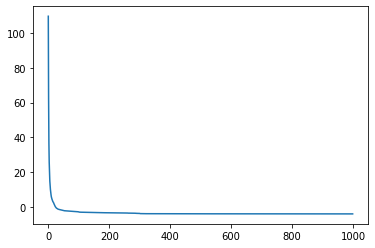

In [10]:
plt.plot(losses)

In [11]:
dim=2
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 110.57756042 time: 0.6821s
Epoch: 0101 loss: -3.69331169 time: 0.7017s
Epoch: 0201 loss: -4.17930269 time: 0.7800s
Epoch: 0301 loss: -4.41982412 time: 0.7632s
Epoch: 0401 loss: -4.63670969 time: 0.8093s
Epoch: 0501 loss: -4.77226210 time: 0.6982s
Epoch: 0601 loss: -4.89972544 time: 0.7106s
Epoch: 0701 loss: -4.98489046 time: 0.6949s
Epoch: 0801 loss: -4.98489046 time: 0.7264s
Epoch: 0901 loss: -5.00621414 time: 0.7856s
Optimization Finished!
Total time elapsed: 754.2754s


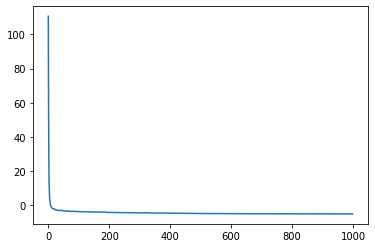

In [12]:
plt.plot(losses)

In [13]:
dim=3
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 110.80858612 time: 0.7024s
Epoch: 0101 loss: -3.65180826 time: 0.7435s
Epoch: 0201 loss: -4.13985968 time: 0.7392s
Epoch: 0301 loss: -4.43265438 time: 0.7577s
Epoch: 0401 loss: -4.66943121 time: 0.7453s
Epoch: 0501 loss: -4.86277246 time: 0.7630s
Epoch: 0601 loss: -4.97093678 time: 0.7521s
Epoch: 0701 loss: -5.09241009 time: 0.7373s
Epoch: 0801 loss: -5.16851854 time: 0.7160s
Epoch: 0901 loss: -5.23402643 time: 0.7507s
Optimization Finished!
Total time elapsed: 751.4584s


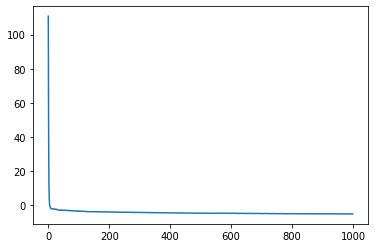

In [14]:
plt.plot(losses)

In [15]:
dim=4
adj_norm,mu,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 112.17070007 time: 0.7292s
Epoch: 0101 loss: -3.54459333 time: 0.7563s
Epoch: 0201 loss: -3.87136388 time: 0.7689s
Epoch: 0301 loss: -4.21124220 time: 0.7514s
Epoch: 0401 loss: -4.43713760 time: 0.8645s
Epoch: 0501 loss: -4.63915920 time: 0.7411s
Epoch: 0601 loss: -4.77234411 time: 0.7536s
Epoch: 0701 loss: -5.06856489 time: 0.7451s
Epoch: 0801 loss: -5.11429787 time: 0.7861s
Epoch: 0901 loss: -5.16417646 time: 0.7469s
Optimization Finished!
Total time elapsed: 763.0309s


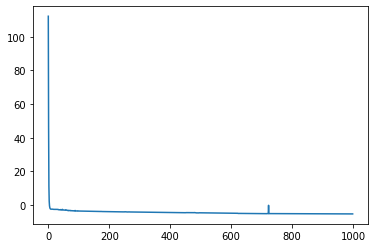

In [16]:
plt.plot(losses)